In [51]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy as sc
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [52]:
class momentum_factors_algo():


    def __init__(self):
        self.etf = 'SPY'
        self.lag =20 # number of lags to adjust for look ahead error
        self.tickers = self.get_etf_holdings_ticks() # getting the tickers for the sp500
        self.spy_etf_df = yf.download('SPY', period= '10Y')['Adj Close'][-1260 : -1].shift(self.lag).dropna(how= 'all')
        self.selected_time_interval = 252 * 5 # there is 252 trading days per year, multiply times five to get 1,260 days. this will serve as the time interval that we want to look at, we want to look at 5-years of data
        self.etf_holdings_price = yf.download(self.tickers, period= '12Y')[['Adj Close', 'Volume']] # Importing the stocks from the ticker list and getting the adjusted close prices and volume of each stock
        
        # Storing data related to backtest from the recent 5 years
        self.long_lagged_prices = None
        self.cumm_rets = None
        self.long_cumm_rets = None
        self.short_cumm_rets = None
        self.algo_port_cumm_rets = None

        # Storing data related to the backtest for 5 years ago
        self.cumm_rets_5yr = None
        self.long_cumm_rets_5yr = None
        self.short_cumm_rets_5yr = None
        self.algo_port_cumm_rets_5y = None

        # Storing data related to monthly returns of each basket, sp500, and portfolio of long and short baskets
        self.long_lagged_monthly_rets = None
        self.short_lagged_monthly_rets = None
        self.algo_port_lagged_monthly_rets = None
        self.sp500_monthly_rets = None

        # Storing data related to the backtest for the efficient frontier optimal portfolios
        self.max_sharpe_cumm_ret = None
        self.min_vol_cumm_ret = None
        self.etf_cumm_rets = None

    # Getting the tickers of the sp500 from a publicly listed ETF
    def get_etf_holdings_ticks(self):
        
        # Read S&P 500 ticker symbols
        sp500_df = pd.read_excel(
            "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
            header=4)
        
        # Replace ".B" with "-B" in ticker symbols, this is the listing for Berkshire Hathaway security
        tickers = sp500_df["Ticker"].dropna().replace(["BRK.B", "BF.B"],["BRK-B", "BF-B"])

        # Remove "-" from the list, this is the listing for cash in the ETF
        tickers = tickers[tickers != "-"].to_list()

        return tickers
    
    
    # Function method to get the corresponding lagged data from our dataframe based on slicing on the number of days that we set back our data for to perform our back-test
    def get_lagged_price_data(self, days_set_back):
        
        # Setting a varaible to get the date that our data should start from
        from_date = days_set_back + self.selected_time_interval

        # Setting a variable to get the to date our date should end
        to_date = days_set_back + 1

        # Slicing our date to get our adjusted close prices starting from_date and ending on to_date and then shifting the date by our number of lag
        lagged_adjprices = self.etf_holdings_price['Adj Close'][-from_date : -to_date].shift(self.lag).dropna(how = 'all')

        return lagged_adjprices


    def calc_momentum_factors(self, days_set_back):
        
        lagged_adjprices = self.get_lagged_price_data(days_set_back)
    
        factors_df = pd.DataFrame(index= self.tickers) # Putting the tickers into a pandas dataframe
        
        # Slope for 52-week trend
        lagged_rolling_mean_price = lagged_adjprices.rolling(window= 52*5).mean().dropna(how='all') # 52 week rolling price average
        lagged_rolling_mean_price['day'] = np.arange(1, len(lagged_rolling_mean_price) + 1) # Counting the number of days within the our sliced data

        for stock in lagged_rolling_mean_price.iloc[:,:len(self.tickers)].columns: # iterating through the columns to obtain the tickers in the ETF
            
            if lagged_rolling_mean_price[stock].notna().all(): # Conditional statement to check if the values are not null within our data set
                
                slope_52_week_trend = np.polyfit(lagged_rolling_mean_price['day'], lagged_rolling_mean_price[stock], 1)[0].round(3) # if so we run a regression to get the 52 week slope trend
            
            else:
                
                slope_52_week_trend = np.nan # if conditional satetment is not true we assing a nan value to that data
            
            factors_df.loc[stock, '52_week_slope'] = slope_52_week_trend # assigning the slope to the repective ticker in our pandas dataframe

        # Percent above 260 day low
        percent_above_260 = (lagged_adjprices - lagged_adjprices.rolling(window= 260).min()) / lagged_adjprices.rolling(window= 260).min() # Calculating the percent above 260 days low
        factors_df['percent_above_260_day_low'] = percent_above_260.dropna(how= 'all').mean().round(3) # Assigning the values to each of its respective ticker in the pandas datafrane

        # Calculate 4/52 price oscillator. Formula: (rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100)
        price_oscillator = (lagged_adjprices.rolling(window=4*5).mean() - lagged_adjprices.rolling(window=52*5).mean()) / lagged_adjprices.rolling(window=52*5).mean()
        factors_df['4/52week_price_oscillator'] = price_oscillator.dropna(how = 'all').mean().round(3) # Assigning the values to each of its respective ticker in the pandas datafrane

        # Calculating 39 week return and assigning the values to each of its respective ticker in the pandas datafrane
        factors_df['returns_39week_period'] = lagged_adjprices.pct_change(periods= 39 * 5).mean().dropna(how = 'all').round(3)

        # Calculating 51 week volume price trend
        volume_lag_rollmean = self.etf_holdings_price['Volume'].shift(self.lag).dropna(how= 'all').rolling(51*5).mean().dropna(how= 'all') # First lagging our volume data, second getting 51 week rolling average volume
        vpt_51wkly = (volume_lag_rollmean * lagged_adjprices.pct_change(periods= 51*5)).cumsum().dropna(how= 'all').round(3) # Getting the product of the 51 week rolling returns and 51 week rolling average volume. Then getting the cumulative sum overtime of the volume price trend

        factors_df['volume_price_trend'] = vpt_51wkly.mean().round(3) # Assigning the values to each of its respective ticker in the pandas datafrane
        
        # Returning our data frame storing all of the factor calculated data
        return factors_df
    

    def calculate_z_scores(self, x): # where x is equal to the momentum factors
       
        z_scores = (x - x.mean()) / x.std() # standard z score formula. Normalizing our momentum factors
        z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
        # The z-score is the number of standard deviations away from the mean a data point is.
        momentum_factors_z_scores = z_scores.sort_values(ascending=False)
        
        return momentum_factors_z_scores


    # function to calculate our cumulative returns
    def calculate_cumulative_returns(self, dataf): 
        
        # Calculating the returns of the provided dataframe
        returns = dataf.pct_change()

        # Getting the cumulative return over time for every security and then getting the average returns of each day for the portfolio. This is done by getting the cumulative product over time since returns are compounded overtime and then getting the daily average returns by averaging out all the returns for the basket for the day.
        cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100

        return cumulative_returns


    def calc_backtest(self):
        
        # Calculating momentum factors, calculating z-scores, getting long and short baskets from z-scores, getting lagged pricing data for each basket based on data from the recent 5 years and then calculating the cumalative returns to plot the back-test
        momentum_factors_df = self.calc_momentum_factors(0)
        long_basket = self.calculate_z_scores(momentum_factors_df)[:10] # selects the top 10 z-scores
        short_basket = self.calculate_z_scores(momentum_factors_df)[-10:] # selects the bottom 10 z-scores
        sp500_lagged_prices = self.get_lagged_price_data(0) # Getting lagged prices for our sp500
        self.long_lagged_prices = sp500_lagged_prices[long_basket.index] # slicing based on the ticker that we have on our calculated long bascket
        short_lagged_prices = sp500_lagged_prices[short_basket.index] # slicing based on the ticker that we have on our calculated short bascket
        algo_port_prices = pd.merge(short_lagged_prices, self.long_lagged_prices, left_index= True, right_index= True, how= 'inner') # merging our short and long basket price data to get our portfolio price data
        self.cumm_rets = self.calculate_cumulative_returns(sp500_lagged_prices) # Getting cumulative returns for the sp500
        self.long_cumm_rets = self.calculate_cumulative_returns(self.long_lagged_prices) # Getting cumulative returns for the long basket
        self.short_cumm_rets = self.calculate_cumulative_returns(short_lagged_prices) # Getting cumulative returns for our short basket
        self.algo_port_cumm_rets = self.calculate_cumulative_returns(algo_port_prices) # Getting cumulative returns for the portfolio of long and short baskets

        # Calculating momentum factors, calculating z-scores, getting long and short baskets from z-scores, getting lagged pricing data for each basket based on data from five years ago and then calculating the cumalitive returns to plot the back-test
        momentum_factors_5yr = self.calc_momentum_factors(252 * 5)
        long_basket_5yr = self.calculate_z_scores(momentum_factors_5yr)[:10]
        short_basket_5yr = self.calculate_z_scores(momentum_factors_5yr)[-10:]
        sp500_lagged_prices_5y = self.get_lagged_price_data(252 * 5)
        long_lagged_prices_5y = sp500_lagged_prices_5y[long_basket_5yr.index]
        short_lagged_prices_5y = sp500_lagged_prices_5y[short_basket_5yr.index]
        algo_port_prices_5y = pd.merge(short_lagged_prices_5y, long_lagged_prices_5y, left_index= True, right_index= True, how= 'inner')
        self.cumm_rets_5yr = self.calculate_cumulative_returns(sp500_lagged_prices_5y) # Getting cumulative returns for the sp500 based on data from 5 years ago
        self.long_cumm_rets_5yr = self.calculate_cumulative_returns(long_lagged_prices_5y) # Getting cumulative returns for the short basket based on data from 5 years ago
        self.short_cumm_rets_5yr = self.calculate_cumulative_returns(short_lagged_prices_5y) # Getting cumulative returns for the long basket based on data from 5 years ago
        self.algo_port_cumm_rets_5y = self.calculate_cumulative_returns(algo_port_prices_5y) # Getting cumulative returns for the protfolio of long and short basket based on data from 5 years ago

        # Calculating the monthly returns for the short and long baskets, portfolio and the sp500
        self.long_lagged_monthly_rets = self.long_lagged_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of our long basket portfolio
        self.short_lagged_monthly_rets = short_lagged_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of our short basket portfolio
        self.algo_port_lagged_monthly_rets = algo_port_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of our portfolio of long and short basket
        self.sp500_monthly_rets = sp500_lagged_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of the sp500

        return
    

    def plot_short_long_backtest_from_recent5yrs(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.long_cumm_rets.plot(label='Long Basket', lw=2) # lw is line width
        self.cumm_rets.plot(label='SP500', lw =2)
        self.short_cumm_rets.plot(label='Short Basket', lw=2)

        plt.legend()
        plt.title('Cumulative Returns')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()
        
        return
    
    
    def plot_portfolio_backtest_from_recent5yrs(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.cumm_rets.plot(label='SP500', lw =2)
        self.algo_port_cumm_rets.plot(label='Portfolio', lw=2)

        plt.legend()
        plt.title('Portfolio vs ETF Cumulative Returns')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()

        return
    
    
    def plot_short_long_backtest_from_5yrsback(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.long_cumm_rets_5yr.plot(label='Long Basket', lw=2)
        self.cumm_rets_5yr.plot(label='SP500', lw =2)
        self.short_cumm_rets_5yr.plot(label='Short Basket', lw=2)

        plt.legend()
        plt.title('Cumulative Returns (Back-Tested Five-Years Ago)')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()

        return
    

    def plot_portfolio_backtest_from_5yrsback(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.cumm_rets_5yr.plot(label='SP500', lw =2)
        self.algo_port_cumm_rets_5y.plot(label='Portfolio', lw=2)

        plt.legend()
        plt.title('Portfolio vs. ETF Cumulative Returns (Back-Tested Five-Years Ago)')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()
        
        return


    def plot_long_basket_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.long_lagged_monthly_rets.index, self.long_lagged_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.long_lagged_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('Long Basket Monthly Returns', pad=9)
        plt.show()

        return
    

    def plot_short_basket_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.short_lagged_monthly_rets.index, self.short_lagged_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.short_lagged_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('Short Basket Monthly Returns', pad=9)
        plt.show()
        
        return
    

    def plot_portfolio_basket_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.algo_port_lagged_monthly_rets.index, self.algo_port_lagged_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.algo_port_lagged_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('Portfolio Monthly Returns (Long + Short Basket)', pad=9)
        plt.show()
        
        return


    def plot_sp500_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.sp500_monthly_rets.index, self.sp500_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.sp500_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('SP500 Monthly Returns', pad=9)
        plt.show()

        return
    

    def calc_eff_frontier(self):
        
        # Run the efficient frontier and montecarlo python file
        %run efficient_frontier_berry_cox.py

        efficient_frontier = eff_frontier(self.long_lagged_prices) # Accesing the class defined within the file and importing the data for our long basket

        efficient_frontier.montecarlo_sim() # Monte Carlo simulation

        efficient_frontier.calculatedresults() # calucalting our efficient frontier results

        self.opt_sharpe_port_wghts = efficient_frontier.maxsharpe_port_weights.values / 100
        self.opt_minvol_port_wghts = efficient_frontier.minvol_port_weights.values / 100

        return efficient_frontier
    
    def calc_opt_eff_front_backtest(self):
        # Partial credit: https://www.codingfinance.com/post/2018-04-10-cumulative-portfolio-returns-py/
        
        # Maximum Sharpe Ration Portfolio Cumalative Returns Calculations
        long_sharpe_basket_lagged_rets = self.long_lagged_prices.pct_change().dropna(how= 'all')

        for value, stock in zip(self.opt_sharpe_port_wghts, long_sharpe_basket_lagged_rets.columns):
            if value == 0:
               long_sharpe_basket_lagged_rets.drop(columns=stock, inplace=True)

        max_sharpe_port_wghts = self.opt_sharpe_port_wghts[self.opt_sharpe_port_wghts != 0]
        
        self.max_sharpe_port_weighted_returns = (max_sharpe_port_wghts * long_sharpe_basket_lagged_rets)
        self.max_sharpe_cumm_ret = (1 + self.max_sharpe_port_weighted_returns.sum(axis= 1)).cumprod() * 100

        # Minimum Volatility Portfolio Cumalative Returns Calculations
        long_minvol_basket_lagged_rets = self.long_lagged_prices.pct_change().dropna(how= 'all')
        
        for value, stock in zip(self.opt_minvol_port_wghts, long_minvol_basket_lagged_rets.columns):
            if value == 0:
                long_minvol_basket_lagged_rets.drop(columns=stock, inplace=True)

        min_vol_port_wghts = self.opt_minvol_port_wghts[self.opt_minvol_port_wghts != 0]
 
        self.min_vol_port_weighted_returns = (min_vol_port_wghts * long_minvol_basket_lagged_rets)
        self.min_vol_cumm_ret = (1 + self.min_vol_port_weighted_returns.sum(axis= 1)).cumprod() * 100

        # Cumulative Returns for the SPY ETF
        etf_rets = self.spy_etf_df.pct_change().dropna(how= 'all')
        self.etf_cumm_rets = (1+ etf_rets).cumprod() * 100

        return
    
    def plot_opt_ports_backtest(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.etf_cumm_rets.plot(label='SP500', lw =2)
        self.max_sharpe_cumm_ret.plot(label='Max Sharpe Port', lw=2)
        self.min_vol_cumm_ret.plot(label='Minimum Volatility Port', lw=2)

        plt.legend()
        plt.title('Optimal Portfolios vs sp500 Cumulative Returns')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()
        
        return

In [53]:
mfa = momentum_factors_algo()

mfa.calc_backtest()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  503 of 503 completed
/var/folders/sm/0p9xlw3950bcl1jg6rphjx540000gn/T/ipykernel_54319/1246633893.py:99: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  factors_df['returns_39week_period'] = lagged_adjprices.pct_change(periods= 39 * 5).mean().dropna(how = 'all').round(3)
/var/folders/sm/0p9xlw3950bcl1jg6rphjx540000gn/T/ipykernel_54319/1246633893.py:103: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  vpt_51wkly = (volume_lag_rollmean * lagged_adjprices.pct_change(periods= 51*5)).cumsum().dropna(how= 'all').round(3) # Getting the product o

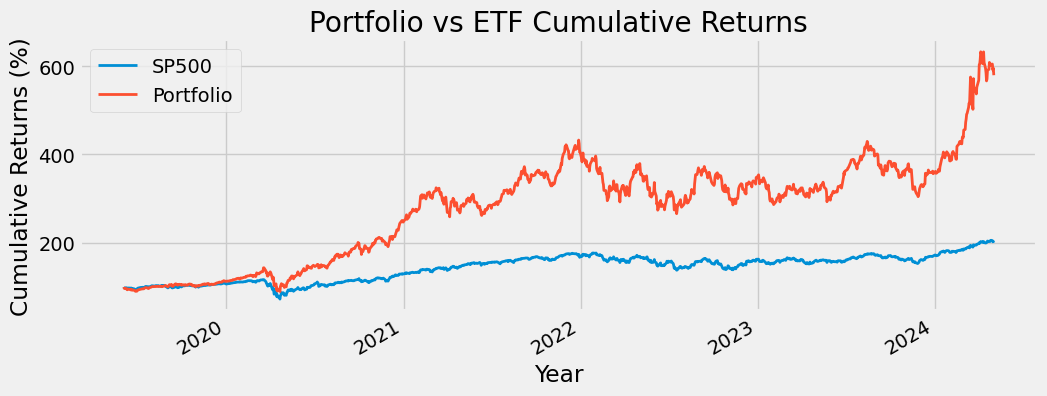

In [54]:
mfa.plot_portfolio_backtest_from_recent5yrs()

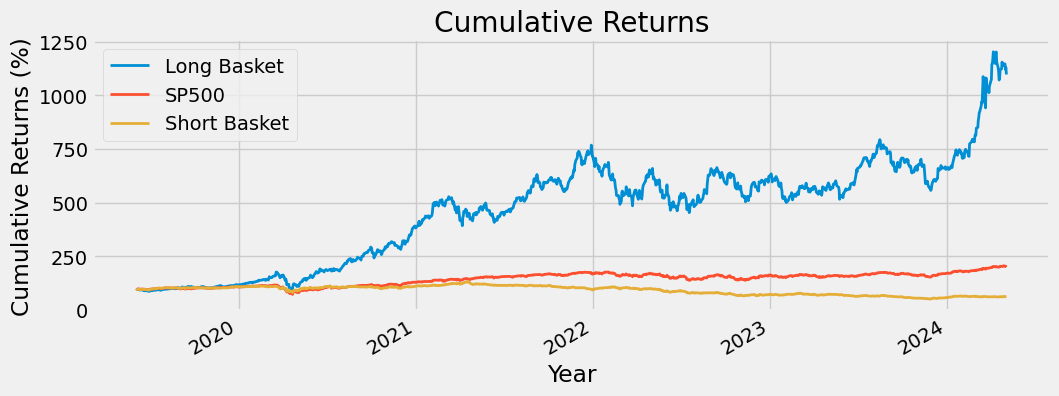

In [55]:
mfa.plot_short_long_backtest_from_recent5yrs()

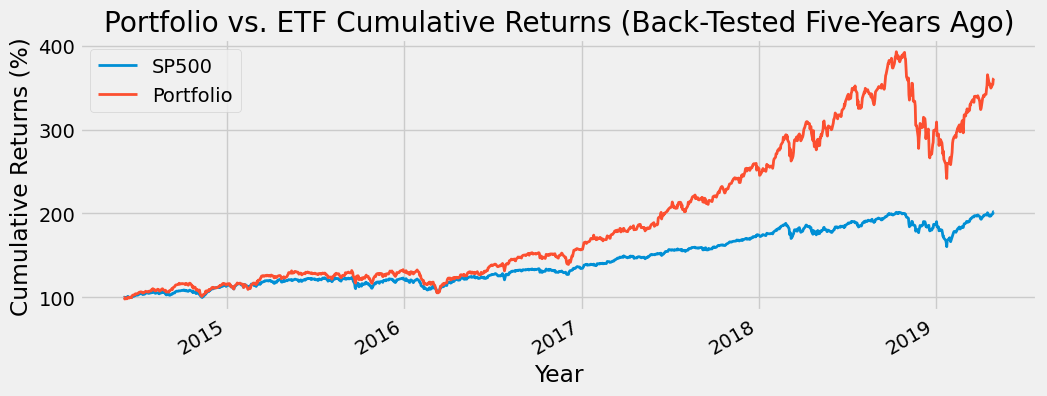

In [56]:
mfa.plot_portfolio_backtest_from_5yrsback()

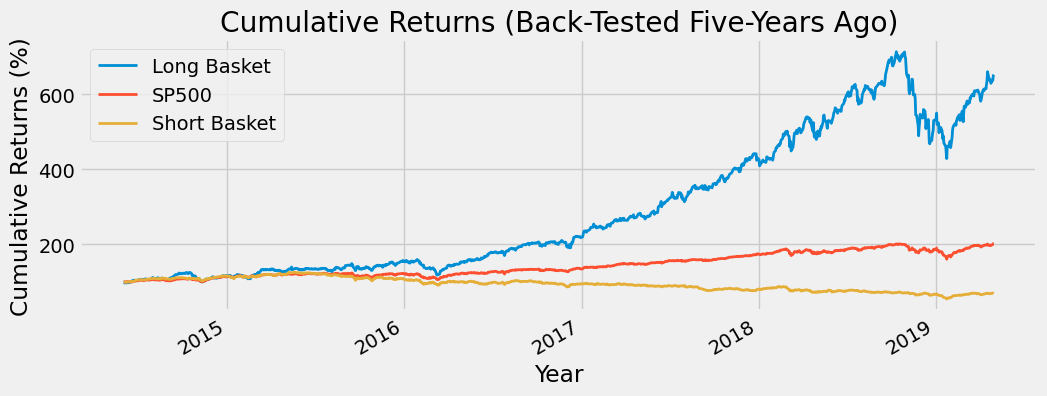

In [57]:
mfa.plot_short_long_backtest_from_5yrsback()

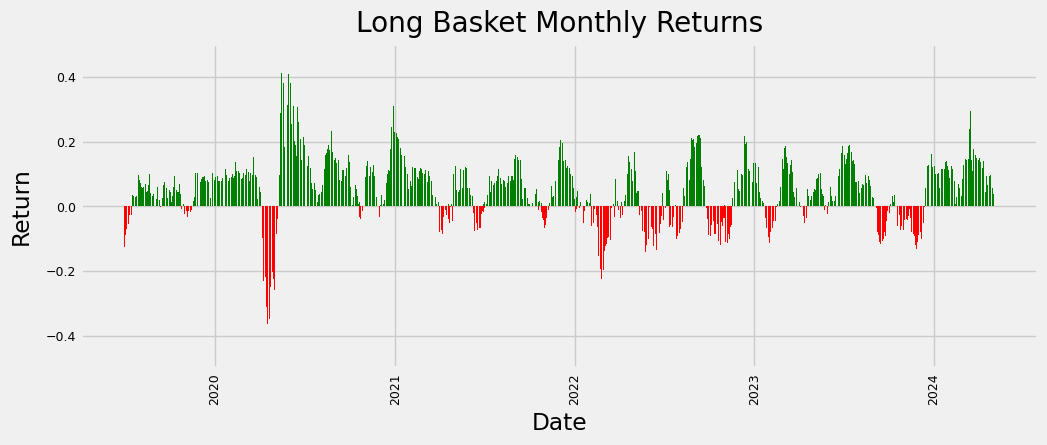

In [58]:
mfa.plot_long_basket_monthly_returns_recent5yrs()

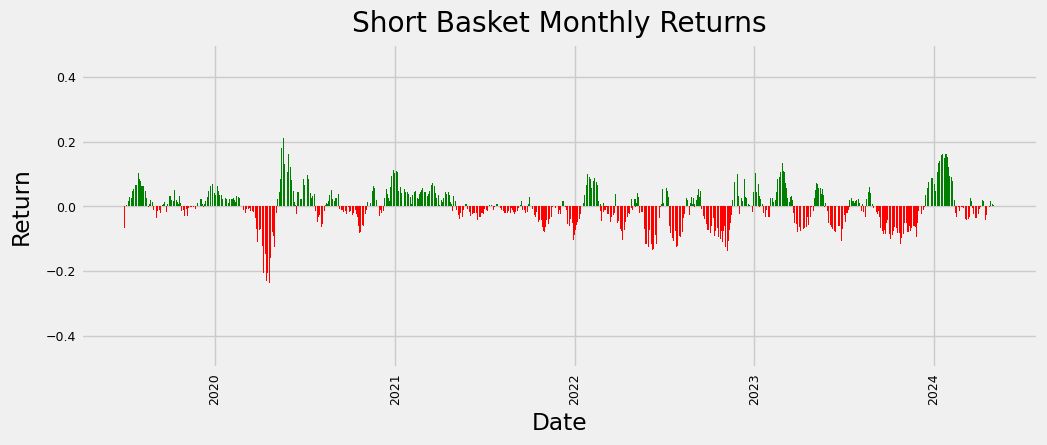

In [59]:
mfa.plot_short_basket_monthly_returns_recent5yrs()

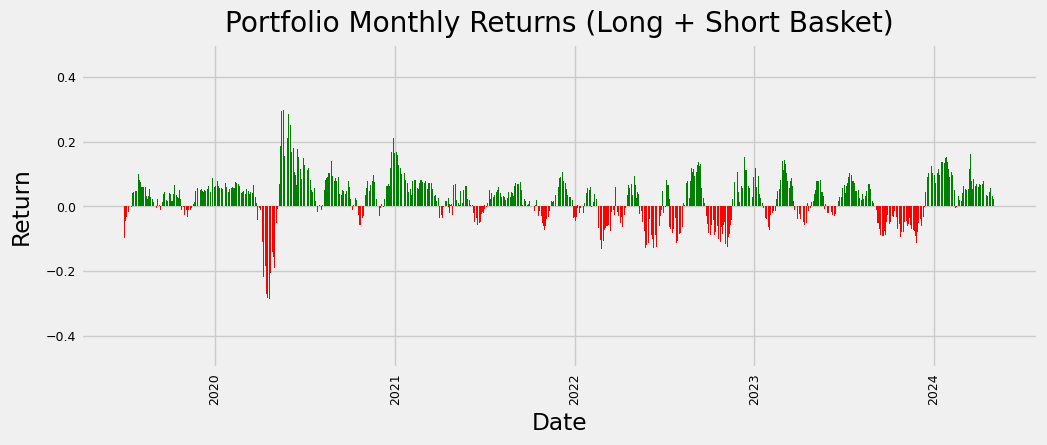

In [60]:
mfa.plot_portfolio_basket_monthly_returns_recent5yrs()

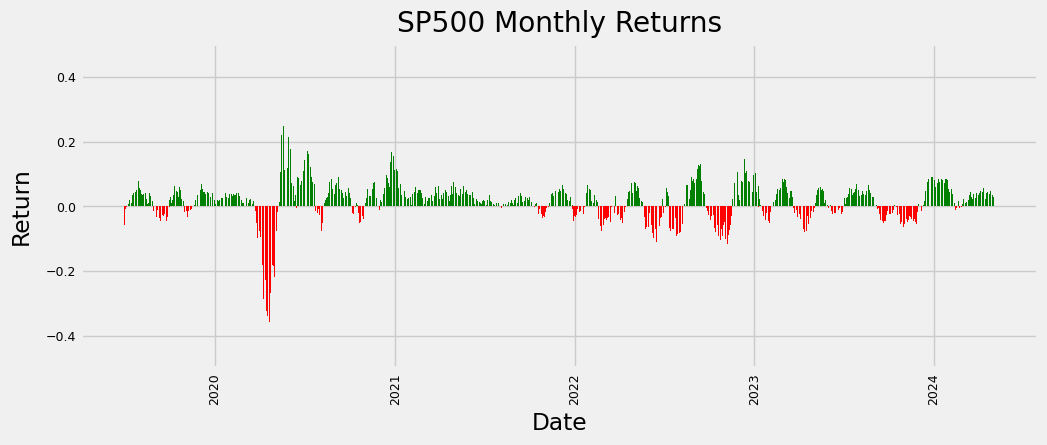

In [61]:
mfa.plot_sp500_monthly_returns_recent5yrs()

In [62]:
efficient_frontier = mfa.calc_eff_frontier()

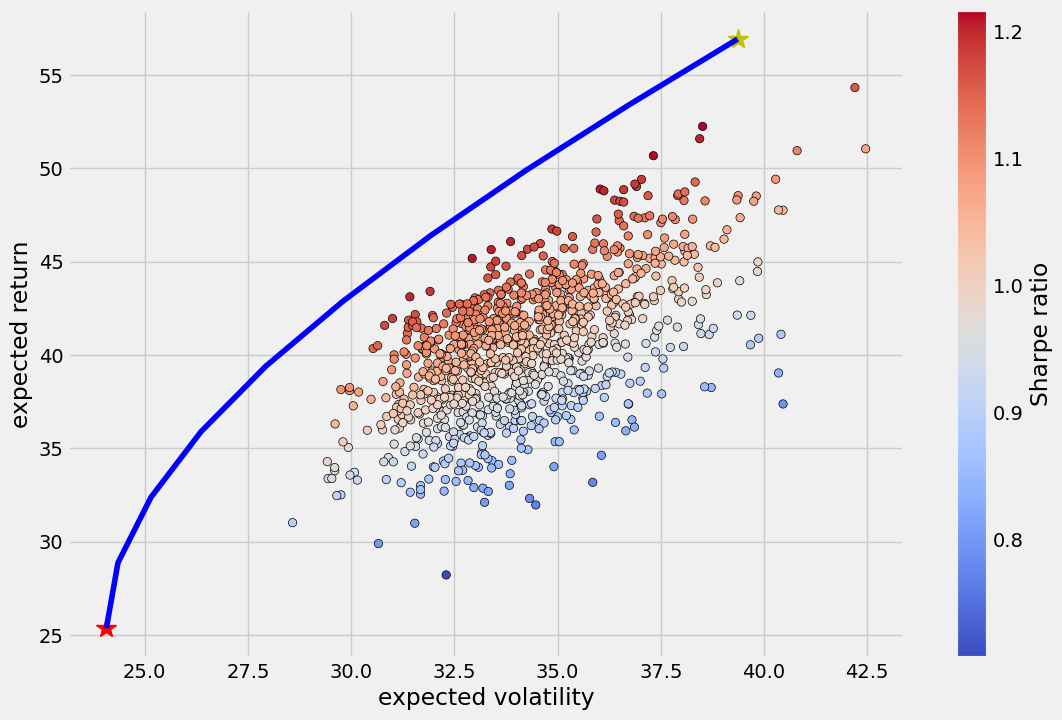

In [63]:
efficient_frontier.plot_efficientfront()

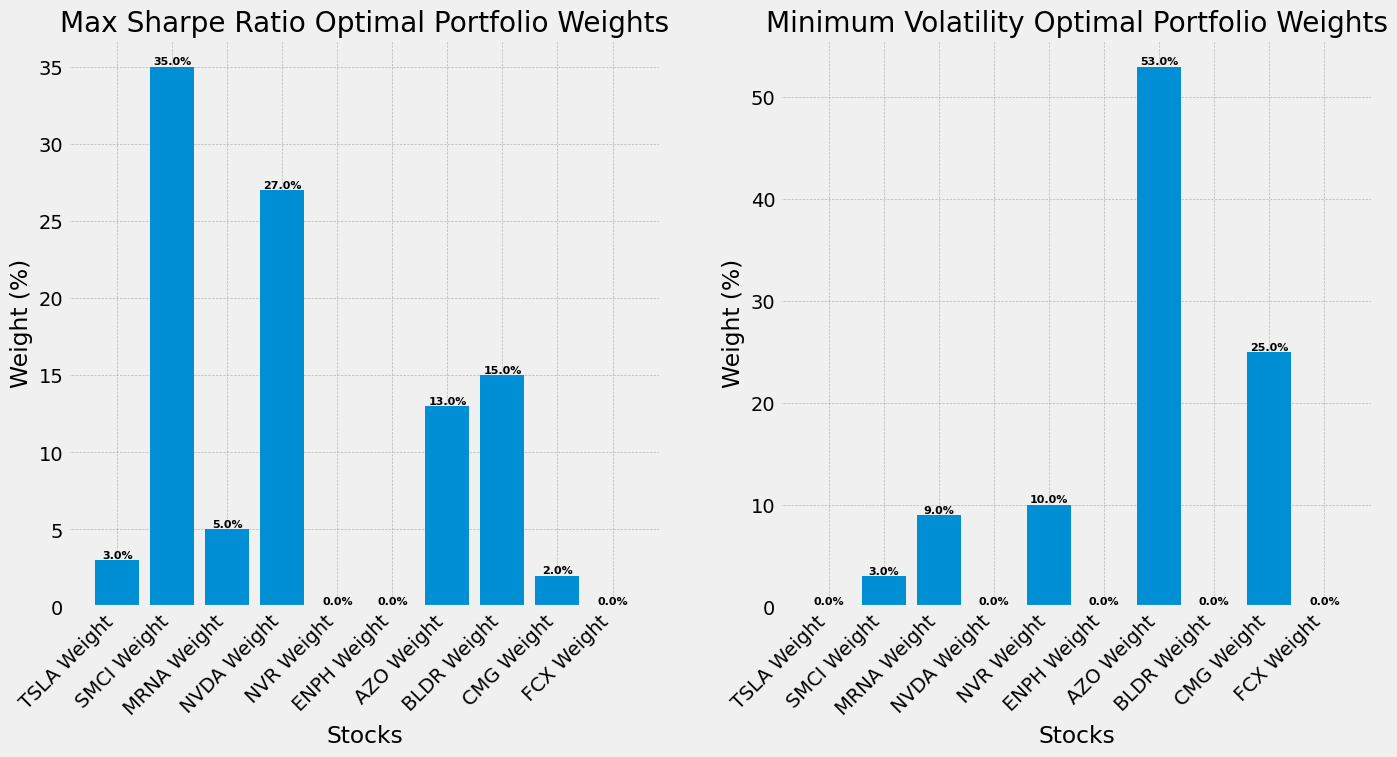

In [64]:
efficient_frontier.plot_optport_weights()

/Users/stevenfernandez/Desktop/Python Class/Quant_Fin_Projects_Assignments/Quant_Fin_CCNY-BIZ-BETZ_Spring_2024_SF_MM/berry_cox_price_momentum_port_gen/efficient_frontier_berry_cox.py:453: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Max Sharpe Ratio Portfolio', 'Minimum Volatility Portfolio'])
/Users/stevenfernandez/Desktop/Python Class/Quant_Fin_Projects_Assignments/Quant_Fin_CCNY-BIZ-BETZ_Spring_2024_SF_MM/berry_cox_price_momentum_port_gen/efficient_frontier_berry_cox.py:469: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Max Sharpe Ratio Portfolio', 'Minimum Volatility Portfolio'])


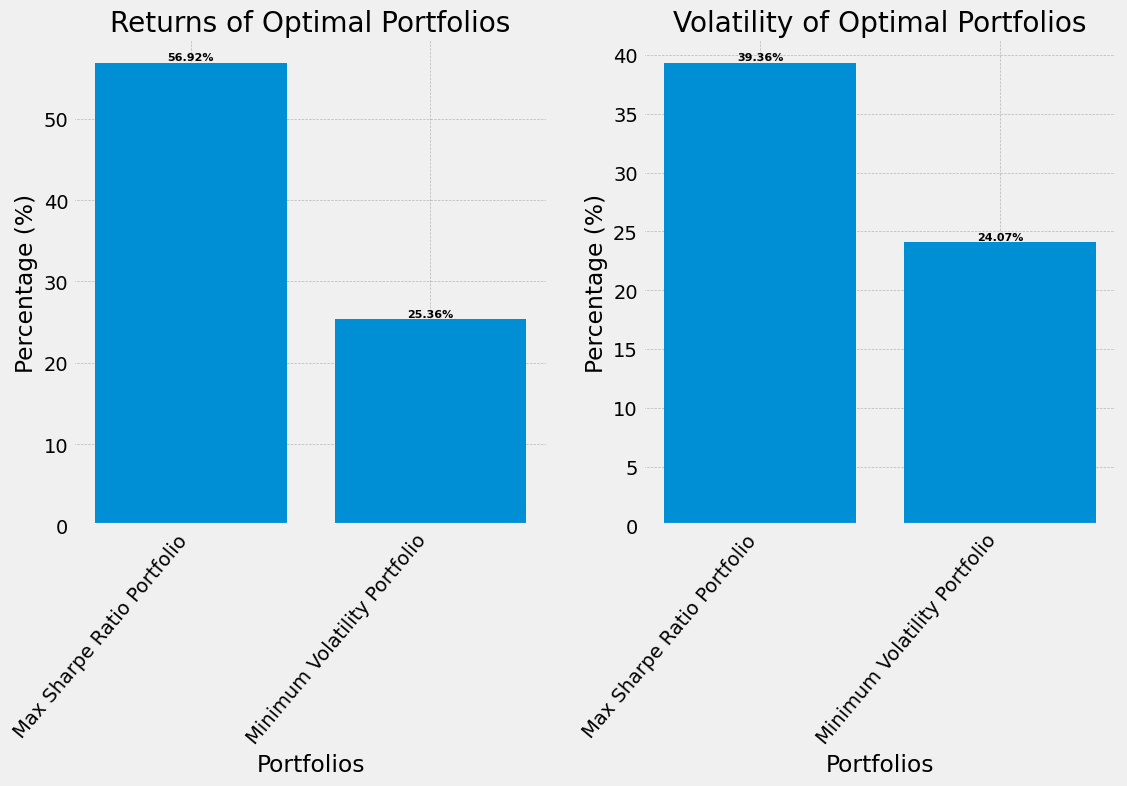

In [65]:
efficient_frontier.plot_rets_vol_optports()

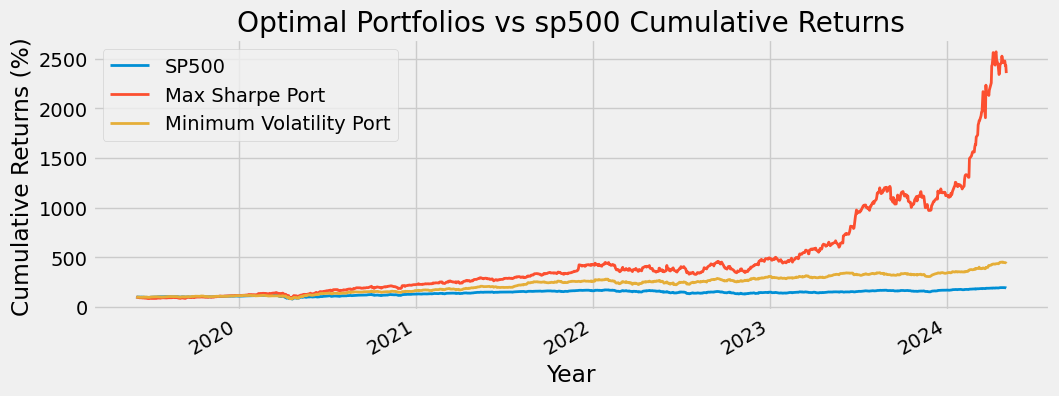

In [66]:
mfa.calc_opt_eff_front_backtest()

mfa.plot_opt_ports_backtest()